## Setting file paths

#### FC-RDM Model 

In [1]:
root = './'
plots_root = root + 'Plots/'
datasets_root = root + 'Datasets/'
behavioural_data_root = root +  'behavioral_data/selected_data/' 
stan_files_root = root +  'stan files/' 
saved_models_root = root + 'stan_results/'

plots_folder_name = 'BERT-RDM/'
dataset_name = 'BERT.csv'
stan_file_name = 'RDM_hier_2k_beta_f.stan'
saved_model_name = 'BERT'

plots_path = plots_root + plots_folder_name
dataset_path = datasets_root + dataset_name
stan_file_path = stan_files_root + stan_file_name
saved_model_path = saved_models_root + saved_model_name  + '.pkl'

## Importing Packages

In [2]:
import numpy as np
import pandas as pd
import pystan
import rlssm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from scipy.stats import gaussian_kde

sns.set_theme(style="whitegrid")


Bad key "text.kerning_factor" on line 4 in
/home/a.dadras/.conda/envs/ANNDDM/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Prepare data

Loading words and non-words with zipf and predicted probabilities

In [3]:
word_nword_df = pd.read_csv(dataset_path, header=None, names =['string', 'freq',  'label', 'zipf','category', 'word_prob', 'non_word_prob'])
word_nword_df

,string,freq,label,zipf,category,word_prob,non_word_prob
0,simples,141,1,1.592864,LF,0.386628,0.613372
1,fluggish,0,0,0.000000,NW,0.652770,0.347230
2,iddustrious,0,0,0.000000,NW,0.034733,0.965267
3,paste,6656,1,3.236317,LF,0.974957,0.025043
4,furtively,76,1,1.768955,LF,0.541270,0.458730
...,...,...,...,...,...,...,...
74312,rattered,0,0,0.000000,NW,0.650757,0.349243
74313,madrogals,0,0,0.000000,NW,0.256779,0.743221
74314,derandas,0,0,0.000000,NW,0.007479,0.992521
74315,pressuraze,0,0,0.000000,NW,0.401949,0.598051


In [4]:
def remove_outliers(df, max_rt, min_rt, std_c=2.5):
    """
    Returns remove outliers from dataframes. Outlier RTs are bigger than
    max_rt and smaller than min_rt. Also RTsthat are out of -/+ (std_c * sd) 
    of mean RT interval are considered as outliers too.

    Parameters
    ----------
        df: pandas dataframe with rt column
        max_rt (float): maximum acceptable rt
        min_rt (float): minimum acceptable rt
        
    Optional Parameters
    ----------
        std_c (float) : Optional
            coefficient to define interval of non-outlier RTs
    
    Returns
    -------
        df: pandas dataframe without outliers  
    """
    mean = df['rt'].mean()
    sd = df['rt'].std()
    lower_thr = mean - std_c*sd
    upper_thr = mean + std_c*sd
    min_bound = max(min_rt, lower_thr)
    max_bound = min(max_rt, upper_thr)
    df = df[df['rt'] >= min_bound]
    df = df[df['rt'] <= max_bound]
    return df

Reading and modifing each behavioral data file and combining all of them into a single behavioral dataframe

In [6]:
Number_Of_Participants = 10
Number_Of_Trials = 400
dataframes = []

for i in range(Number_Of_Participants):
    # Loading each file
    df = pd.read_csv(behavioural_data_root + str(i+1) + "DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # Dropping non rows and first two rows that are demographic informations 
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    # Converting columns type to suitable data types
    convert_dict = {'string_type': 'int16',
                    'accuracy': 'int16',
                    'rt': float
                   }

    df = df.astype(convert_dict)
    # Convert RTs to seconds
    df['rt'] = df['rt'].apply(lambda x: x/1000) 
    # Removing Outliers
    df = remove_outliers(df, 3, .2, 2.5)
    # Extracting response of participant from his/her accuracy
    df['response'] = np.logical_not(np.logical_xor(df['string_type'], df['accuracy'])).astype('int')
    df = df.reset_index(drop=True)
    # Particpant number
    df['participant'] = i+1
    # Minimum RT of participant in all trials (is needed for stan code)
    df['minRT'] = df['rt'].min()
    dataframes.append(df)

In [7]:
# Combining dataframes
behavioural_df = pd.concat(dataframes)
# Merging  behavioral dataframe with word_nonword_df to have words and non-words data with behavioral data
behavioural_df = pd.merge(behavioural_df, word_nword_df, on='string', how='left').dropna().reset_index(drop=True)
behavioural_df = behavioural_df.drop(["trial", "string_type", "freq"], axis=1)

In [8]:
behavioural_df.head()

,accuracy,rt,string,response,participant,minRT,label,zipf,category,word_prob,non_word_prob
0,0,0.707,bookie,0,1,0.412,1.0,3.409105,LF,0.765460,0.234540
1,1,0.769,gandbrake,0,1,0.412,0.0,0.000000,NW,0.196695,0.803305
2,1,0.526,philosophical,1,1,0.412,1.0,3.205648,LF,0.929074,0.070926
3,0,0.510,umbeaten,1,1,0.412,0.0,0.000000,NW,0.108697,0.891303
4,1,0.512,belonging,1,1,0.412,1.0,3.317140,LF,0.990028,0.009972


Predicted probabilities of words and non-words in different conditions in all trials
across participants

In [9]:
behavioural_df.groupby(['category']).agg({'word_prob': ['mean', 'std', 'count', 'max', 'min'], 'non_word_prob': ['mean', 'std', 'count', 'max', 'min']})

word_prob                                     non_word_prob  \
              mean       std count       max       min          mean   
category                                                               
HF        0.916930  0.118660   197  0.999876  0.271366      0.083070   
LF        0.776781  0.242393  1462  0.999801  0.012417      0.223219   
NW        0.155612  0.207915  1907  0.996567  0.001972      0.844388   

                                              
               std count       max       min  
category                                      
HF        0.118660   197  0.728634  0.000124  
LF        0.242393  1462  0.987583  0.000199  
NW        0.207915  1907  0.998028  0.003433

RT and response description of words and non-words in different conditions in all trials
across participants

In [10]:
behavioural_df.groupby(['category']).agg({'rt': ['mean', 'std', 'max', 'min'], 'response': ['mean', 'std', 'max', 'min']})

rt                          response                  
              mean       std    max    min      mean       std max min
category                                                              
HF        0.607244  0.182378  1.453  0.301  0.994924  0.071247   1   0
LF        0.737378  0.275658  2.376  0.271  0.867305  0.339361   1   0
NW        0.810100  0.265811  2.491  0.200  0.123230  0.328787   1   0

## Stan Model and Estimation

Compiling stan model

In [11]:
rdm_model = pystan.StanModel(file=stan_file_path)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecf2ea2142dda9448cf351d10cd95b5f NOW.


Preparing model's inputs

In [12]:
N = len(behavioural_df) # number of all trials
participant = behavioural_df['participant'].to_numpy() # participants number
x = behavioural_df.loc[:, ['word_prob', 'non_word_prob']].to_numpy() # predicted probabilites of words and non-words
frequency = behavioural_df['zipf'].to_numpy() # zipf values
response = behavioural_df['response'].to_numpy().astype(int) # participants responses
rt = behavioural_df['rt'].to_numpy() # participants RTs 
minRT = behavioural_df['minRT'].to_numpy() # participants min RT                     
RTbound = 0

threshold_priors = [4, 2, 1, 2] 
g_priors = [-2, 1, 0, 1] 
m_priors = [0, 0.5, 0, 1] 
alpha_priors = [0, 1, 1, 1]
b_priors = [0, 1, 1, 1];
k_priors = [2, 1, 1, 1]

# define input for the model
data_dict = {'N': N,
             'L': Number_Of_Participants,
             'participant': participant,
             'x' : x,
             'frequency': frequency,
             'response': response,
             'rt': rt,
             'minRT': minRT,
             'RTbound': RTbound,
             'threshold_priors': threshold_priors,
             'g_priors': g_priors,
             'm_priors': m_priors,
             'alpha_priors': alpha_priors,
             'b_priors': b_priors,
             'k_priors': k_priors,
            }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_chains = 2

Fitting the model

In [13]:
fit = rdm_model.sampling(data=data_dict,
                             iter=n_iter, 
                             warmup=n_warmup,
                             chains=n_chains,
                             verbose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Model diagnostics

In [14]:
print("***hmc diagnostics:")
print(pystan.check_hmc_diagnostics(fit), flush=True)

***hmc diagnostics:
{'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


In [15]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

print("***DF: ")
df

***DF: 


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_g,-4.801662,0.017101,0.575729,-6.053062,-5.166991,-4.765131,-4.395171,-3.774925,1133.472084,1.001595
mu_m,0.141133,0.002624,0.051211,0.027962,0.112554,0.144632,0.175532,0.230424,380.794058,1.008417
mu_threshold_word,1.079986,0.003712,0.097412,0.883627,1.016241,1.081209,1.145133,1.272591,688.560883,1.000321
mu_threshold_nonword,1.606548,0.013987,0.176575,1.263932,1.492991,1.601715,1.710887,1.967803,159.382518,1.013319
mu_alpha,0.962319,0.010310,0.260214,0.434287,0.791055,0.957294,1.138743,1.474913,637.033461,1.001337
...,...,...,...,...,...,...,...,...,...,...
log_lik[3563],0.495463,0.001675,0.058540,0.377973,0.456272,0.498176,0.534685,0.603154,1221.717781,0.998965
log_lik[3564],0.939848,0.001840,0.060653,0.824422,0.901172,0.938217,0.981541,1.059336,1086.278983,1.005369
log_lik[3565],-1.132621,0.005202,0.174450,-1.473270,-1.247773,-1.127409,-1.017195,-0.806137,1124.487372,0.998763
log_lik[3566],0.312791,0.002161,0.074350,0.160855,0.260699,0.317635,0.362953,0.454962,1183.434772,0.999202


In [16]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["Rhat"]:
    if f >= 1.01 or f <= 0.9:
        counter+=1
print(counter)

***Rhat > 1.01: 
365


In [17]:
df.loc[df['Rhat']>1.01]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_threshold_nonword,1.606548,0.013987,0.176575,1.263932,1.492991,1.601715,1.710887,1.967803,159.382518,1.013319
sd_m,0.063256,0.003578,0.051897,0.003860,0.023604,0.051262,0.086683,0.206375,210.379470,1.018387
sd_threshold_word,0.237776,0.005718,0.091526,0.094438,0.179624,0.229067,0.281935,0.441159,256.249945,1.012265
z_threshold_nonword[4],-0.065920,0.024383,0.436070,-0.939448,-0.358017,-0.053584,0.231049,0.770494,319.836761,1.012960
z_threshold_nonword[8],-0.436440,0.027509,0.428396,-1.300798,-0.703739,-0.426902,-0.153618,0.389940,242.522942,1.010936
...,...,...,...,...,...,...,...,...,...,...
transf_mu_threshold_nonword,1.791500,0.011692,0.147382,1.512776,1.695687,1.785327,1.876999,2.098624,158.884818,1.013404
log_lik[1579],-1.421292,0.007004,0.171365,-1.804087,-1.524449,-1.412786,-1.298204,-1.133383,598.584946,1.010801
log_lik[1672],-1.596378,0.005634,0.150251,-1.912295,-1.694438,-1.585720,-1.493698,-1.323997,711.315687,1.010538
log_lik[1785],-1.447825,0.007781,0.190953,-1.860530,-1.567210,-1.443655,-1.309540,-1.130099,602.194574,1.010263


In [18]:
df.loc[df['Rhat']>1.01].describe()

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.678884,0.003454,0.045959,0.583770,0.648309,0.681694,0.710770,0.760260,324.740612,1.011126
std,8.210438,0.044097,0.488545,7.199321,7.879663,8.234042,8.547942,9.085895,34.839420,0.000854
min,-1.596378,0.000764,0.013625,-1.912295,-1.694438,-1.585720,-1.493698,-1.323997,122.404104,1.010263
25%,0.258632,0.000767,0.013644,0.229243,0.249846,0.260317,0.268818,0.280375,316.517506,1.010571
50%,0.262913,0.000836,0.015207,0.232005,0.253234,0.264204,0.273139,0.288682,331.276461,1.011469
75%,0.262913,0.000836,0.015207,0.232005,0.253234,0.264204,0.273139,0.288682,331.276461,1.011469
max,157.060164,0.842276,9.318639,137.664447,150.718732,157.513410,163.529248,173.832003,711.315687,1.022182


Saving Model

In [19]:
with open(saved_model_path, "wb") as f:
    pickle.dump({'model' : rdm_model, 'fit' : fit}, f, protocol=-1)

/home/a.dadras/.conda/envs/ANNDDM/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


## Check parameters

Loading Model

In [20]:
with open(saved_model_path, "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

Parameters posterior plots

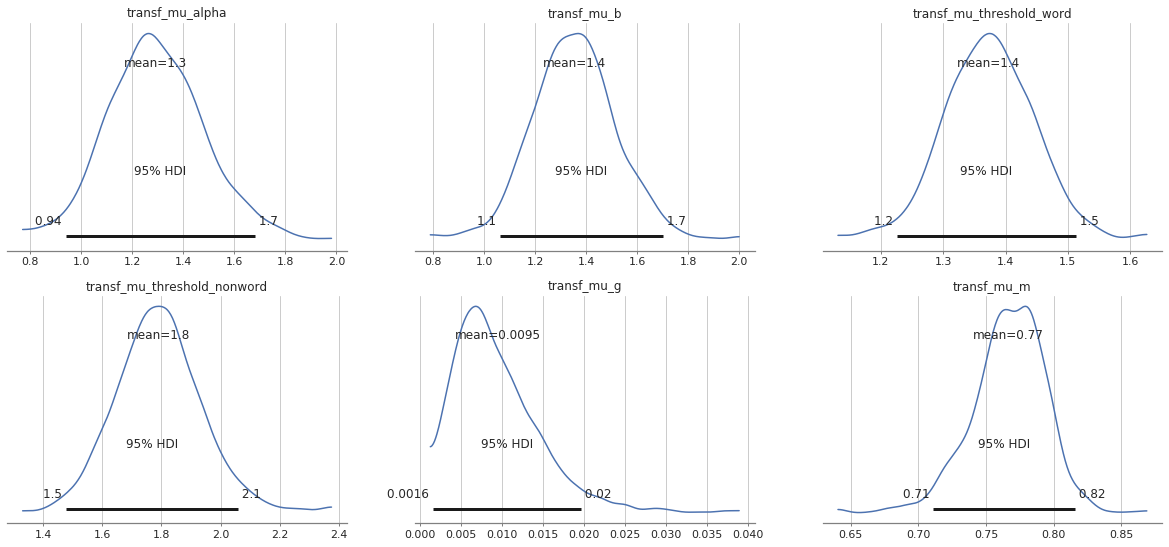

In [22]:
az.plot_posterior(fit, var_names=['transf_mu_alpha', 'transf_mu_b', 'transf_mu_threshold_word', 'transf_mu_threshold_nonword', 'transf_mu_g', 'transf_mu_m'], hdi_prob=.95);
plt.savefig(plots_path + 'Parameters')

#### Models mean parameters in different conditions

In [23]:
# Loading model parameters for each trial
drift_word_t = fit['drift_word_t']
drift_nonword_t = fit['drift_nonword_t']
threshold_t_word = fit['threshold_t_word']
threshold_t_nonword = fit['threshold_t_nonword']
ndt_t = fit['ndt_t']

In [24]:
HF_condition_w = drift_word_t[:, behavioural_df['category']=="HF"]
HF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="HF"]
LF_condition_w = drift_word_t[:, behavioural_df['category']=="LF"]
LF_condition_nw = drift_nonword_t[:, behavioural_df['category']=="LF"]
NW_condition_w = drift_word_t[:, behavioural_df['category']=="NW"]
NW_condition_nw = drift_nonword_t[:, behavioural_df['category']=="NW"]

In [25]:
print('HF words, word drift mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword drift mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word drift mean and std:
5.140272551475367 0.10672596855348492
HF words, nonword drift mean and std:
2.089602933338188 0.10213017904282203


In [26]:
print('LF words word drift mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword drift mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word drift mean and std:
3.3027705233477387 0.08407924202525965
LF words nonword drift mean and std:
2.394790129227437 0.09942841584076201


In [27]:
print('NW words word drift mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword drift mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word drift mean and std:
0.6770935868433442 0.08578166053284993
NW words nonword drift mean and std:
3.4450796253382303 0.08692231335979536


In [28]:
HF_condition_w = threshold_t_word[:, behavioural_df['category']=="HF"]
HF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="HF"]
LF_condition_w = threshold_t_word[:, behavioural_df['category']=="LF"]
LF_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="LF"]
NW_condition_w = threshold_t_word[:, behavioural_df['category']=="NW"]
NW_condition_nw = threshold_t_nonword[:, behavioural_df['category']=="NW"]

In [29]:
print('HF words, word threshold mean and std:')
print(np.mean(np.mean(HF_condition_w, axis=1)), np.std(np.mean(HF_condition_w, axis=1)))
print('HF words, nonword threshold mean and std:')
print(np.mean(np.mean(HF_condition_nw, axis=1)), np.std(np.mean(HF_condition_nw, axis=1)))

HF words, word threshold mean and std:
1.3824943075500136 0.04921074485665506
HF words, nonword threshold mean and std:
1.7713289176635612 0.05906753818274273


In [30]:
print('LF words word threshold mean and std:')
print(np.mean(np.mean(LF_condition_w, axis=1)), np.std(np.mean(LF_condition_w, axis=1)))
print('LF words nonword threshold mean and std:')
print(np.mean(np.mean(LF_condition_nw, axis=1)), np.std(np.mean(LF_condition_nw, axis=1)))

LF words word threshold mean and std:
1.373595140099206 0.049258001138150175
LF words nonword threshold mean and std:
1.7931450291717406 0.05981442773621341


In [31]:
print('NW words word threshold mean and std:')
print(np.mean(np.mean(NW_condition_w, axis=1)), np.std(np.mean(NW_condition_w, axis=1)))
print('NW words nonword threshold mean and std:')
print(np.mean(np.mean(NW_condition_nw, axis=1)), np.std(np.mean(NW_condition_nw, axis=1)))

NW words word threshold mean and std:
1.3741162809240395 0.0492064085420586
NW words nonword threshold mean and std:
1.7763162777891857 0.05908818890643657


In [32]:
HF_condition = ndt_t[:, behavioural_df['category']=="HF"]
LF_condition = ndt_t[:, behavioural_df['category']=="LF"]
NW_condition = ndt_t[:, behavioural_df['category']=="NW"]

In [33]:
print('HF words ndt_t mean and std:')
print(np.mean(np.mean(HF_condition, axis=1)), np.std(np.mean(HF_condition, axis=1)))

HF words ndt_t mean and std:
0.3211495485779463 0.008661123153619417


In [34]:
print('LF words ndt_t mean and std:')
print(np.mean(np.mean(LF_condition, axis=1)), np.std(np.mean(LF_condition, axis=1)))

LF words ndt_t mean and std:
0.31170926759276835 0.008469841993041854


In [35]:
print('Non Words ndt_t mean and std:')
print(np.mean(np.mean(NW_condition, axis=1)), np.std(np.mean(NW_condition, axis=1)))

Non Words ndt_t mean and std:
0.3209556964687264 0.008867510285506277


## Calculating metrics

In [36]:
def calculate_waic(log_likelihood, pointwise=False):
    """
    Returns model comparisions' metrics.
    
    Parameters
    ----------
        log_likelihood: np.array
            log_likelihood of each trial
        max_rt: float
            maximum acceptable rt
        min_rt: float
             minimum acceptable rt
             
    Optional Parameters
    ----------------
    pointwise: float
        if true pointwise waic will be calculated
        
    Returns
    -------
        out:  a dictionary containing lppd, waic, waic_se and pointwise_waic    
    """
    likelihood = np.exp(log_likelihood)

    mean_l = np.mean(likelihood, axis=0) # N observations

    pointwise_lppd = np.log(mean_l)
    lppd = np.sum(pointwise_lppd)

    pointwise_var_l = np.var(log_likelihood, axis=0) # N observations
    var_l = np.sum(pointwise_var_l)

    pointwise_waic = - 2*pointwise_lppd +  2*pointwise_var_l
    waic = -2*lppd + 2*var_l
    waic_se = np.sqrt(log_likelihood.shape[1] * np.var(pointwise_waic))

    if pointwise:
        out = {'lppd':lppd,
               'p_waic':var_l,
               'waic':waic,
               'waic_se':waic_se,
               'pointwise_waic':pointwise_waic}
    else:
        out = {'lppd':lppd,
               'p_waic':var_l,
                'waic':waic,
                'waic_se':waic_se}
    return out

In [37]:
log_likelihood = fit['log_lik']
calculate_waic(log_likelihood)

{'lppd': 249.6011095264248,
 'p_waic': 71.3565990668083,
 'waic': -356.489020919233,
 'waic_se': 145.6860315605472}

## Simulating RDM with estimated parameters

In [38]:
def random_rdm_2A(cor_drift, inc_drift, threshold_word, threshold_nonword, ndt, noise_constant=1, dt=0.001, max_rt=10):
    """ 
    Simulates behavior (rt and accuracy) according to the Racing Diffusion Model.
     
    Parameters
    ----------
    cor_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - correct trials.
    inc_drift : numpy.ndarray
        Drift-rate of the Racing Diffusion Model - incorrect trials.
    threshold : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Threshold of the diffusion decision model.
    ndt : numpy.ndarray
        Shape is usually (n_samples, n_trials).
        Non decision time of the diffusion decision model, in seconds.
    
    Optional Parameters
    ----------------
    noise_constant : float, default 1
        Scaling factor of the Racing Diffusion Model.
        If changed, drift and threshold would be scaled accordingly.
        Not to be changed in most applications.
    dt : float, default 0.001
        Controls the time resolution of the Racing Diffusion Model. Default is 1 msec.
        Lower values of dt make the function more precise but much slower.
    max_rt : float, default 10
        Controls the maximum rts that can be predicted.
        Making this higher might make the function a bit slower.
    
    Returns
    -------
    rt : numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated response times according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    acc: numpy.ndarray
        Shape is the same as the input parameters.
        Contains simulated accuracy according to the Racing Diffusion Model.
        Every element corresponds to the set of parameters given as input with the same shape.
    """
    shape = cor_drift.shape
    acc = np.empty(shape)
    rt = np.empty(shape)
    acc[:] = np.nan
    rt[:] = np.nan

    max_tsteps = max_rt/dt

    x_cor = np.zeros(shape)
    x_inc = np.zeros(shape)

    tstep = 0
    ongoing = np.array(np.ones(shape), dtype=bool)

    stop_race = False

    while np.sum(ongoing) > 0 and tstep < max_tsteps:
        x_cor[ongoing] += np.random.normal(cor_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        x_inc[ongoing] += np.random.normal(inc_drift[ongoing]*dt,
                                           noise_constant*np.sqrt(dt),
                                           np.sum(ongoing))
        tstep += 1
        ended_correct = (x_cor >= threshold_word)
        ended_incorrect = (x_inc >= threshold_nonword)

        # store results and filter out ended trials
        if np.sum(ended_correct) > 0:
            acc[np.logical_and(ended_correct, ongoing)] = 1
            rt[np.logical_and(ended_correct, ongoing)] = dt*tstep + ndt[np.logical_and(ended_correct, ongoing)]
            ongoing[ended_correct] = False

        if np.sum(ended_incorrect) > 0:
            acc[np.logical_and(ended_incorrect, ongoing)] = 0
            rt[np.logical_and(ended_incorrect, ongoing)] = dt*tstep + ndt[np.logical_and(ended_incorrect, ongoing)]
            ongoing[ended_incorrect] = False
    return rt, acc

Simulating RDM with estimated parameters

In [39]:
pp_rt, pp_response = random_rdm_2A(drift_word_t, drift_nonword_t, threshold_t_word, threshold_t_nonword, ndt_t, noise_constant=1, dt=0.001, max_rt=5)

In [40]:
def bci(x, alpha=0.05):
    """
    Calculate Bayesian credible interval (BCI).
    
    Parameters
    ----------
    x : array-like
        An array containing MCMC samples.
    
    Optional Parameters
    -------------------
    alpha : float, default 0.05
        Desired probability of type I error.
    
    Returns
    -------
    interval : numpy.ndarray
        Array containing the lower and upper bounds of the bci interval.
    """
    interval = np.nanpercentile(x, [(alpha/2)*100, (1-alpha/2)*100])

    return interval

In [41]:
# Predicted Data
rt_predictions = pd.concat((pd.DataFrame(pp_rt, index=pd.Index(np.arange(1, len(pp_rt)+1))).T, behavioural_df['category']), axis=1)
response_predictions = pd.concat((pd.DataFrame(pp_response, index=pd.Index(np.arange(1, len(pp_response)+1))).T, behavioural_df['category']), axis=1)

# Experiment Data
experiment_data = behavioural_df.loc[:, ['rt', 'response', 'category']]

Separating RT and Response of predicted and experimental data for each condition

In [42]:
HF_data = experiment_data.loc[experiment_data['category']=='HF']
LF_data = experiment_data.loc[experiment_data['category']=='LF']
NW_data = experiment_data.loc[experiment_data['category']=='NW']

HF_pred_rt = rt_predictions.loc[rt_predictions['category']=='HF']
HF_pred_resp = response_predictions.loc[response_predictions['category']=='HF']
LF_pred_rt = rt_predictions.loc[rt_predictions['category']=='LF']
LF_pred_resp = response_predictions.loc[response_predictions['category']=='LF']
NW_pred_rt = rt_predictions.loc[rt_predictions['category']=='NW']
NW_pred_resp = response_predictions.loc[response_predictions['category']=='NW']

## Quantiles Posterior Predictions

In [43]:
quantiles = [.1, .3, .5, .7, .9]
percentiles = np.array(quantiles)*100

In [44]:
# experiment Data quantile
HF_quantile_ex = HF_data['rt'].quantile(quantiles)
LF_quantile_ex = LF_data['rt'].quantile(quantiles)
NW_quantile_ex = NW_data['rt'].quantile(quantiles)

# predicted data quantiles (for each sample)
HF_quantile_pred = HF_pred_rt.quantile(quantiles, axis=0).T
LF_quantile_pred = LF_pred_rt.quantile(quantiles, axis=0).T
NW_quantile_pred = NW_pred_rt.quantile(quantiles, axis=0).T

# predicted data quantiles bci
HF_predicted_bci = np.array([bci(HF_quantile_pred[x]) for x in quantiles])
LF_predicted_bci = np.array([bci(LF_quantile_pred[x]) for x in quantiles])
NW_predicted_bci = np.array([bci(NW_quantile_pred[x]) for x in quantiles])

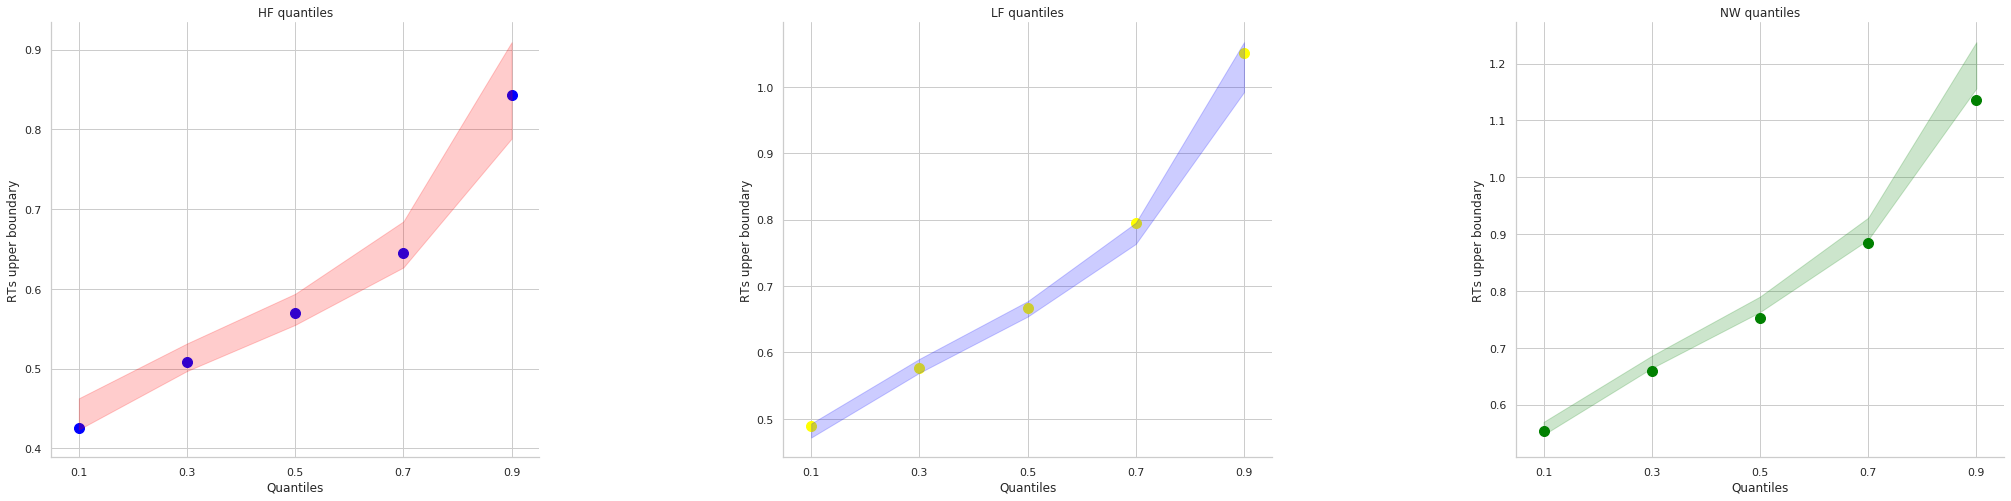

In [45]:
fig, axes = plt.subplots(1,3 , figsize=(35,8))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes[0].set_title('HF quantiles')
axes[1].set_title('LF quantiles')
axes[2].set_title('NW quantiles')

axes[0].scatter(quantiles, HF_quantile_ex, color='blue', s=100)
axes[1].scatter(quantiles, LF_quantile_ex, color='yellow', s=100)
axes[2].scatter(quantiles, NW_quantile_ex, color='green', s=100)

axes[0].fill_between(quantiles,
                HF_predicted_bci[:, 0],
                HF_predicted_bci[:, 1],
                HF_predicted_bci[:, 0] < HF_predicted_bci[:, 1],  color = 'red', alpha=0.2)

axes[1].fill_between(quantiles,
                LF_predicted_bci[:, 0],
                LF_predicted_bci[:, 1],
                LF_predicted_bci[:, 0] < LF_predicted_bci[:, 1],  color = 'blue', alpha=0.2)

axes[2].fill_between(quantiles,
                NW_predicted_bci[:, 0],
                NW_predicted_bci[:, 1],
                NW_predicted_bci[:, 0] < NW_predicted_bci[:, 1],  color = 'green', alpha=0.2)


for ax in axes:
        ax.set_xlabel('Quantiles')
        ax.set_xticks(quantiles)
        ax.set_xticklabels(quantiles)
        ax.set_ylabel('RTs upper boundary')

sns.despine()
plt.savefig(plots_path + 'Quantiles Poseterior')

## Mean Accuracy and RT Posterior Plots

In [46]:
HF_data_rt_mean = HF_data['rt'].mean()
LF_data_rt_mean = LF_data['rt'].mean()
NW_data_rt_mean = NW_data['rt'].mean()

HF_pred_rt_mean = HF_pred_rt.mean(axis=0)
LF_pred_rt_mean = LF_pred_rt.mean(axis=0)
NW_pred_rt_mean = NW_pred_rt.mean(axis=0)


HF_data_resp_mean = HF_data['response'].mean()
LF_data_resp_mean = LF_data['response'].mean()
NW_data_resp_mean = NW_data['response'].mean()

HF_pred_resp_mean = HF_pred_resp.mean(axis=0)
LF_pred_resp_mean = LF_pred_resp.mean(axis=0)
NW_pred_resp_mean = NW_pred_resp.mean(axis=0)


In [47]:
def plot_posterior(x, data_mean, ax):
    """
    Plots the posterior of x with experimental data mean as a line
    
    Parameters
    ----------
    x : array-like
        An array containing RT or response for each trial.
        
    x : float
        mean of RT or Accuracy of experimental data.

    ax : matplotlib.axes.Axes
        
    Returns
    -------
    None
    """
    density = gaussian_kde(x, bw_method='scott')
    xd = np.linspace(x.min(), x.max())
    yd = density(xd)

    low, high = bci(x)
    ax.fill_between(xd[np.logical_and(xd >= low, xd <= high)],
                     yd[np.logical_and(xd >= low, xd <= high)])

    ax.plot(xd, yd)
    ax.axvline(data_mean, color='red')

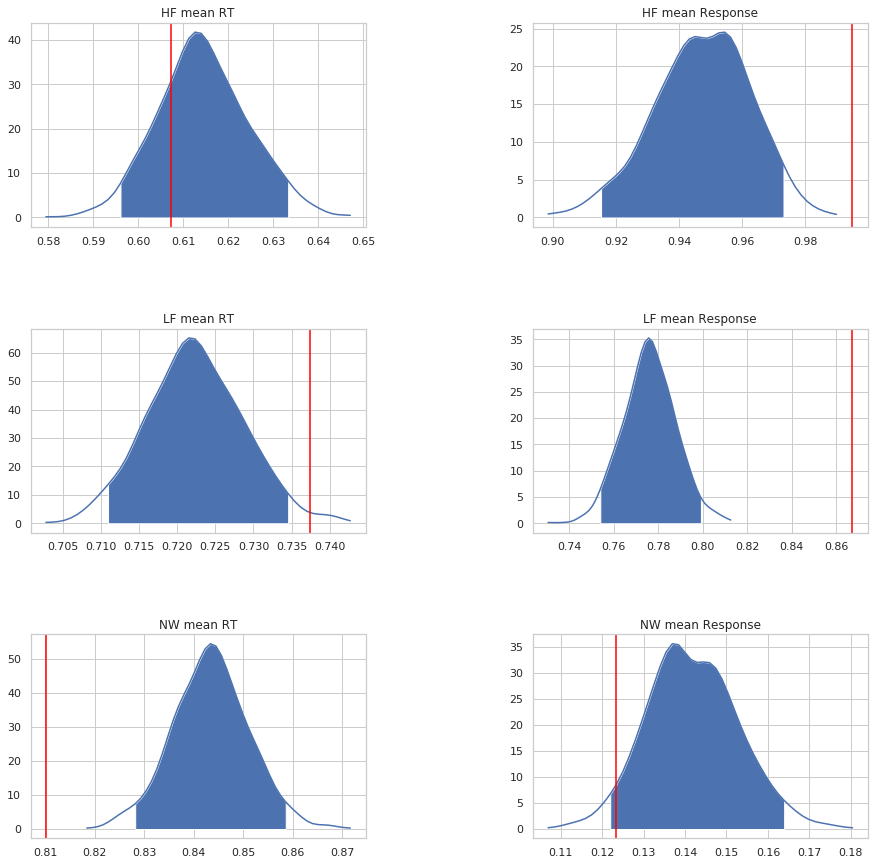

In [48]:
fig, axes = plt.subplots(3,2 , figsize=(15,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

axes[0][0].set_title('HF mean RT')
axes[0][1].set_title('HF mean Response')
axes[1][0].set_title('LF mean RT')
axes[1][1].set_title('LF mean Response')
axes[2][0].set_title('NW mean RT')
axes[2][1].set_title('NW mean Response')

plot_posterior(HF_pred_rt_mean, HF_data_rt_mean, axes[0][0])
plot_posterior(HF_pred_resp_mean, HF_data_resp_mean, axes[0][1])

plot_posterior(LF_pred_rt_mean, LF_data_rt_mean, axes[1][0])
plot_posterior(LF_pred_resp_mean, LF_data_resp_mean, axes[1][1])

plot_posterior(NW_pred_rt_mean, NW_data_rt_mean, axes[2][0])
plot_posterior(NW_pred_resp_mean, NW_data_resp_mean, axes[2][1])

plt.savefig(plots_path + 'Mean Accuracy and RT')